<a href="https://colab.research.google.com/github/jkarenko/Function-Approximation/blob/main/Function_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

genetic algorithm to approximate a transfer function

In [478]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [549]:
target = {
    -1: -.88,
    -.9: -.87,
    -.8: -.86,
    -.7: -.84,
    -.6: -.80,
    -.5: -.65,
    -.4: -.50,
    -.3: -.36,
    -.2: -.23,
    -.1: -.11,
    0: 0,
    .1: .11,
    .2: .26,
    .3: .39,
    .4: .54,
    .5: .64,
    .6: .82,
    .7: .86,
    .8: .87,
    .9: .88,
    1: .88
}

#list(target.values())

In [449]:
for i, k in enumerate({.1:.3, .4:.56}):
  print(i, k)

0 0.1
1 0.4


In [476]:
class Genome:
  def __init__(self, n) -> None:
    self.n = n
    self.fitness = float("inf")
    self.lookup_table = {}
    self.transfer_function = ""
  def _get_equation(self):
    equation = ""
    for nth in self.n:
      value = self.n[nth]
      equation = f" + {value} * X ** {nth}" + equation
    return equation
  def __str__(self):
    newline = "\n"
    return f"Function={self._get_equation()}\nfitness={self.fitness}\nValues from input:\n{f'{newline}'.join(list(map(lambda x: f'{x} -> {self.lookup_table[x]}', self.lookup_table.keys())))}"


In [459]:
def f(input, n):
  equation = ""
  for nth in n:
    value = n[nth]
    equation = f" + {value} * {input} ** {nth}" + equation
  return eval(equation)
#res = f(0.1, {1: .23, 2: .6, 3: .83})
#print(res)

In [528]:
def test_fitness(input, genome, target):
  results = {}
  for i in input:
    results[i] = f(i, genome.n)
  fitness = 0
  for in_val in results:
    out_val = results[in_val]
    target_val = target[in_val]
    if out_val < 0 and target_val < 0:
      fitness = fitness + abs(abs(target_val) - abs(out_val))
    elif out_val < 0 and target_val >= 0:
      fitness = fitness + target_val + abs(out_val)
    elif out_val >= 0 and target_val < 0:
      fitness = fitness + abs(target_val) + out_val
    else:
      fitness = fitness + abs(target_val - out_val)
  genome.fitness = fitness / len(target)
  genome.lookup_table = results
  return genome

In [462]:
def make_random_genome(order):
  n = {}
  for i in range(1, order + 1):
    n[i] = np.random.uniform(-1, 1)
  return Genome(n)
#make_random_genome(order=4).n

In [535]:
def new_genome_from_parents(p1, p2, mutation=.02):
  n = {}
  for i in p1.n:
    n[i] = np.random.choice((p1.n[i], p2.n[i])) * (1 + np.random.uniform(-1 * mutation, mutation))
  return Genome(n)
#new_genome_from_parents(make_random_genome(4), make_random_genome(4)).n

In [558]:
#input_values = np.round(np.arange(-1, 1, 0.1), decimals=2)
input_values = target.keys()

candidates = []
for _ in range(0,10):
  candidates.append(make_random_genome(order=12))
num_generations = 2000
for generation in range(0, num_generations):

  for genome in candidates:
    genome = test_fitness(input_values, genome, target).fitness

  candidates.sort(key = lambda x: x.fitness)

  best_genomes = candidates[:3]

  # print(f"\nBest of generation {generation}: {best_genomes[0].fitness}")

  new_generation = []
  new_generation.append(new_genome_from_parents(best_genomes[0], best_genomes[1]))
  new_generation.append(new_genome_from_parents(best_genomes[0], best_genomes[1]))
  new_generation.append(new_genome_from_parents(best_genomes[0], best_genomes[1]))
  new_generation.append(new_genome_from_parents(best_genomes[1], best_genomes[2]))
  new_generation.append(new_genome_from_parents(best_genomes[1], best_genomes[2]))
  new_generation.append(new_genome_from_parents(best_genomes[0], best_genomes[2]))
  new_generation.append(new_genome_from_parents(best_genomes[0], best_genomes[2]))

  candidates = best_genomes + new_generation

winner = candidates[0]
print(f"Best genome after {num_generations} generations:")
print(winner)
for i, k in enumerate(target):
  print(f"{k} -> {target[k]}")

Best genome after 2000 generations:
Function= + -0.23518836114582345 * X ** 12 + -0.2690691076961011 * X ** 11 + 0.8654592725941679 * X ** 10 + -0.46991929820651324 * X ** 9 + -0.12319909256023824 * X ** 8 + 0.2813236229069797 * X ** 7 + 0.30688828092316117 * X ** 6 + 0.282844611389001 * X ** 5 + -0.5893364316422145 * X ** 4 + -1.6709408878755039 * X ** 3 + 1.4768948384431333 * X ** 2 + 1.0235662627212687 * X ** 1
fitness=0.016563901366787568
Values from input:
-1 -> -0.8793237098513174
-0.9 -> -0.8931976400286495
-0.8 -> -0.8691932753117244
-0.7 -> -0.8221597322743928
-0.6 -> -0.749648100832812
-0.5 -> -0.6503948843611773
-0.4 -> -0.5281883059265216
-0.3 -> -0.3910611209459793
-0.2 -> -0.24959185891714933
-0.1 -> -0.11539886197398543
0 -> 0.0
0.1 -> 0.11539886197398543
0.2 -> 0.24959185891714933
0.3 -> 0.3910611209459793
0.4 -> 0.5281883059265216
0.5 -> 0.6503948843611773
0.6 -> 0.749648100832812
0.7 -> 0.8221597322743928
0.8 -> 0.8691932753117244
0.9 -> 0.8931976400286495
1 -> 0.8793

In [498]:
print(list(winner.lookup_table.values()))

[0.8801234847152333, 0.8726487997014409, 0.8857090108228574, 0.8572668698950923, 0.7786477160920258, 0.6631254780819734, 0.528481348683459, 0.38895104448408624, 0.25287379989218917, 0.1233293060978738, 0.0, -0.1233293060978738, -0.25287379989218917, -0.38895104448408624, -0.528481348683459, -0.6631254780819734, -0.7786477160920258, -0.8572668698950923, -0.8857090108228574, -0.8726487997014409, -0.8801234847152333]


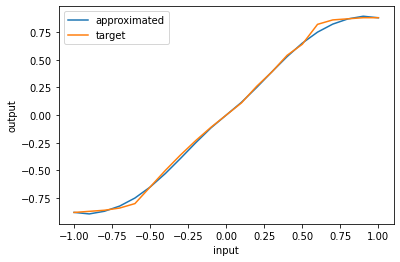

In [559]:
input = list(winner.lookup_table.keys())
output = list(winner.lookup_table.values())
target_values = list(target.values())

plt.plot(input, output, label="approximated")
plt.plot(input, target_values, label="target")
plt.legend()
plt.ylabel("output")
plt.xlabel("input")
plt.show()